In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
from transformers import VisionEncoderDecoderModel,ViTImageProcessor,GPT2Tokenizer,Seq2SeqTrainingArguments,Seq2SeqTrainer
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import nltk
import pandas as pd

In [ ]:
# load the dataset and split into training and testing set(80:20)
dataset = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
dataset['image_path'] = '/kaggle/input/flickr8k/Images/' + dataset['image']
train_df, test_df = train_test_split(dataset, test_size=0.2,  random_state=0)

In [ ]:
# Load the pretrained transformer which needs to be fine-tuned
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k","gpt2")
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
#make changes in the configuration of encoder and decoder so that they are compatible with each other
tokenizer.pad_token = tokenizer.eos_token
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.num_beams = 4

In [ ]:
#create the data suitable for training with transformers
class LoadDataset(Dataset):
    def __init__(self, df,feature_extractor,tokenizer):
        self.images = df['image_path'].values
        self.caption = df['caption'].values
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        inputs = dict()
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt').pixel_values.squeeze()
        caption = self.caption[idx]
        labels = tokenizer(caption,max_length=128,truncation=True, padding='max_length',return_tensors='pt')['input_ids'][0]
        inputs['pixel_values'] = image
        inputs['labels'] = labels
        return inputs
train_ds = LoadDataset(train_df,feature_extractor,tokenizer)
test_ds = LoadDataset(test_df,feature_extractor,tokenizer)

In [ ]:
# defining the arguments used in training
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/image-caption-generator",
    evaluation_strategy="epoch",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10, 
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    overwrite_output_dir = True,
    save_strategy='epoch', 
    report_to='none', 
)
# create the instance for finetuning the model
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)
# Code to start the finetunning process
trainer.train()

In [ ]:
#save the fine tuned model
trainer.save_model('/kaggle/working/image_caption_generator')
feature_extractor.save_pretrained('/kaggle/working/image_caption_generator')
tokenizer.save_pretrained('/kaggle/working/image_caption_generator')

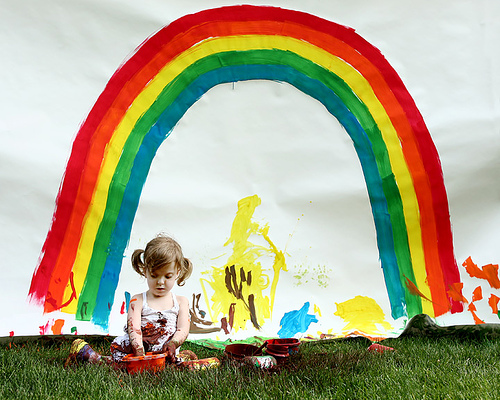

In [1]:
# evaluation of tunemodel
from PIL import Image
img_path = "/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg"
img = Image.open(img_path)
img

In [3]:
# load the finetuned model
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/image-caption-generator")
feature_extractor = ViTImageProcessor.from_pretrained("/kaggle/input/image-caption-generator")
tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/image-caption-generator")

2024-03-28 07:24:27.977015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 07:24:27.977153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 07:24:28.126516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
image_features = feature_extractor(img,return_tensors = 'pt').pixel_values   # extract the image features
captoion_generator = model.generate(image_features,num_beams=4)     #generate the captions based on image features extracted
decode_caption = tokenizer.batch_decode(captoion_generator,skip_special_tokens = True) # decode the caption generation
decode_caption #display the caption genrated by the model

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['A little girl is sitting in front of a rainbow painting.']

In [11]:
#code to evaluate the performance of generated caption with actual caption (blue_score) metrics
generated_caption = "A little girl is sitting in front of a rainbow painting."
references = ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
             'A little girl is sitting in front of a large painted rainbow .',
              'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
              'There is a girl with pigtails sitting in front of a rainbow painting .',
              'Young girl with pigtails painting outside in the grass .'
             ]
generated_caption_tokens = generated_caption.split()
reference_captions_tokens = [caption.split() for caption in references]
bleu_score = nltk.translate.bleu_score.sentence_bleu(reference_captions_tokens, generated_caption_tokens)
bleu_score

0.8931539818068694